In [15]:
import os
import ast
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Summarize baseline results into Pandas DataFrame

In [16]:
def summarize(path, fname):
    model_meta = pd.read_parquet(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_loss', 'train_acc', 'valid_loss', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_loss'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_loss'].apply(lambda x: x[-1])
    model_meta['final_valid_acc'] = model_meta['valid_acc'].apply(lambda x: x[-1])
    model_meta['final_valid_loss'] = model_meta['valid_loss'].apply(lambda x: x[-1])
    model_meta['best_valid_loss'] = model_meta['valid_loss'].apply(min)

    return model_meta

In [17]:
model_meta = pd.DataFrame()

root_dir = '.'
source_train_baseline_dir = '/home/nschiou2/domain_adapt_cxr/experiments/film/fixed_batch_size/film_bn_sparse/film_bn_sparse_s_20k_t_20/'
exp_dir = [d for d in os.listdir(root_dir) if os.path.isdir(d)]

for f in os.listdir(source_train_baseline_dir):
    if f.endswith('.parquet') and f.startswith('source'):
        trial_results = summarize(os.path.join(root_dir, source_train_baseline_dir), f)
        phase, _, iter_idx, _ = re.split('[_.]', f)
        trial_results.loc[:, 'phase'] = phase
        trial_results.loc[:, 'iter_idx'] = iter_idx

        try:
            with open(os.path.join(root_dir, source_train_baseline_dir, f'args_{iter_idx}.json')) as arg_f:
                args = json.load(arg_f)
        except OSError:
            print('No corresponding args.json file associated with trial!')

        for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                    'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
            trial_results.loc[:, key] = args[key]

        model_meta  = model_meta.append(trial_results, ignore_index=True)
    
for d in exp_dir:
    for f in os.listdir(os.path.join(root_dir, d)):
        if (f.endswith('.parquet')) and ('target' in f):
            trial_results = summarize(os.path.join(root_dir, d), f)
            phase, _, iter_idx, _ = re.split('[_.]', f)
            trial_results.loc[:, 'phase'] = phase
            trial_results.loc[:, 'iter_idx'] = iter_idx

            try:
                with open(os.path.join(root_dir, d, f'args_{iter_idx}.json')) as arg_f:
                    args = json.load(arg_f)
            except OSError:
                print('No corresponding args.json file associated with trial!')

            for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                        'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
                trial_results.loc[:, key] = args[key]

            model_meta = model_meta.append(trial_results, ignore_index=True)
        

# Summarize performance for trained models

In [18]:
source_meta = model_meta[model_meta['phase'] == 'source']

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [20]:
source_meta.mean()[performance_cols]

mimic_test_loss       0.612825
mimic_test_acc        0.763516
mimic_test_auc        0.817529
chexpert_test_loss    0.569071
chexpert_test_acc     0.856875
chexpert_test_auc     0.911954
dtype: float64

In [21]:
target_meta = model_meta[model_meta['phase'] == 'target']

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [22]:
target_meta.groupby('n_target_samples').max(numeric_only=True)[performance_cols]

,mimic_test_loss,mimic_test_acc,mimic_test_auc,chexpert_test_loss,chexpert_test_acc,chexpert_test_auc
n_target_samples,,,,,,
20,0.618506,0.773126,0.839554,0.587798,0.820000,0.910386
50,0.621937,0.771747,0.835290,0.598307,0.825875,0.908913
100,0.621051,0.766483,0.833108,0.600960,0.813875,0.907517
200,0.622418,0.770494,0.834468,0.599845,0.813375,0.908030
500,0.622576,0.771371,0.834393,0.602859,0.820125,0.907998
1000,0.623195,0.770369,0.834198,0.602607,0.813000,0.908152


In [23]:
target_meta.groupby('n_target_samples').mean()[performance_cols]

,mimic_test_loss,mimic_test_acc,mimic_test_auc,chexpert_test_loss,chexpert_test_acc,chexpert_test_auc
n_target_samples,,,,,,
20,0.611956,0.769992,0.827916,0.583424,0.795917,0.897832
50,0.614957,0.766274,0.821647,0.587697,0.781542,0.891927
100,0.614640,0.763349,0.819304,0.590492,0.771292,0.891930
200,0.615114,0.765522,0.822723,0.589955,0.774208,0.892434
500,0.615273,0.765522,0.821601,0.591293,0.770917,0.891003
1000,0.615529,0.765981,0.822738,0.592277,0.766792,0.890794


In [24]:
target_meta.groupby('n_target_samples').std()[performance_cols]

,mimic_test_loss,mimic_test_acc,mimic_test_auc,chexpert_test_loss,chexpert_test_acc,chexpert_test_auc
n_target_samples,,,,,,
20,0.005688,0.005105,0.010305,0.006893,0.020875,0.013491
50,0.006127,0.007709,0.013164,0.011984,0.040455,0.015611
100,0.005585,0.004587,0.012356,0.011950,0.038520,0.016000
200,0.006326,0.007450,0.010833,0.011302,0.035776,0.015183
500,0.006371,0.008156,0.012793,0.013752,0.043966,0.016966
1000,0.006640,0.005756,0.010483,0.013080,0.040797,0.016867


In [25]:
mimic_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc'])
chex_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc'])

Text(0.5, 1.0, 'Chexpert test performance')

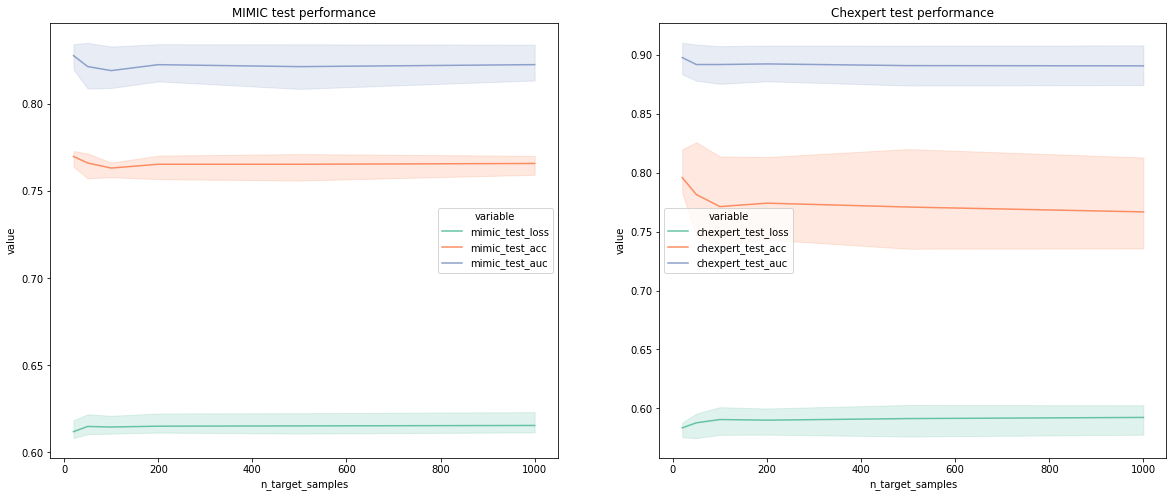

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=mimic_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[0])
ax[0].set_title('MIMIC test performance')
sns.lineplot(data=chex_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[1])
ax[1].set_title('Chexpert test performance')

# Visualize training and validation losses for the two training phases

In [27]:
def plot_losses(df, phase='target', n_target_samples=20, loss_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{loss_type}_loss'
    max_len = max([len(ele) for ele in subset_df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in subset_df.loc[:, key].values]
    losses = np.stack(stackable)

    avg_loss = np.mean(losses, axis=0)
    upper_ = avg_loss + np.std(losses, axis=0)
    lower_ = avg_loss - np.std(losses, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_loss, 'k--')
    ax.plot(losses.T)
    ax.legend(['average loss', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='upper right')

    ax.set_title(f'{loss_type} loss on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('BCE loss')


## 20 MIMIC samples

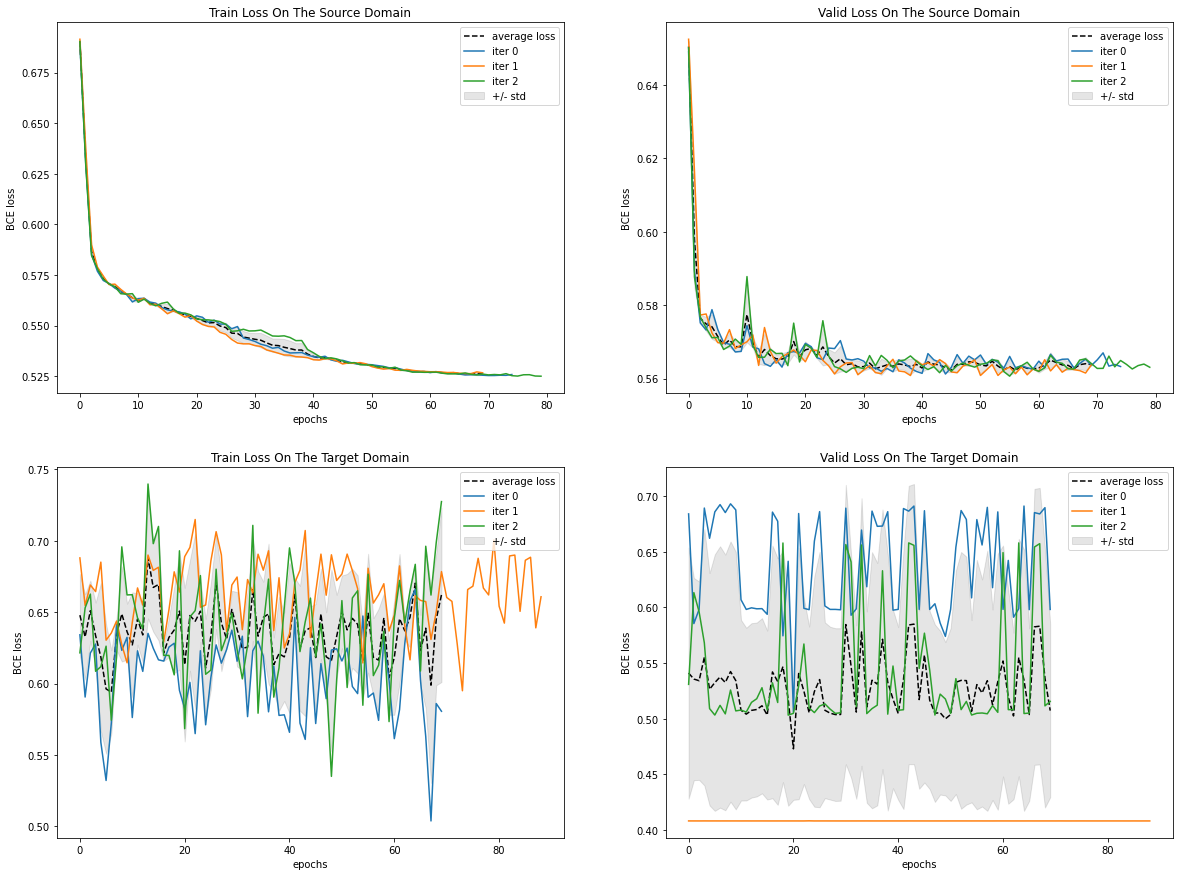

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

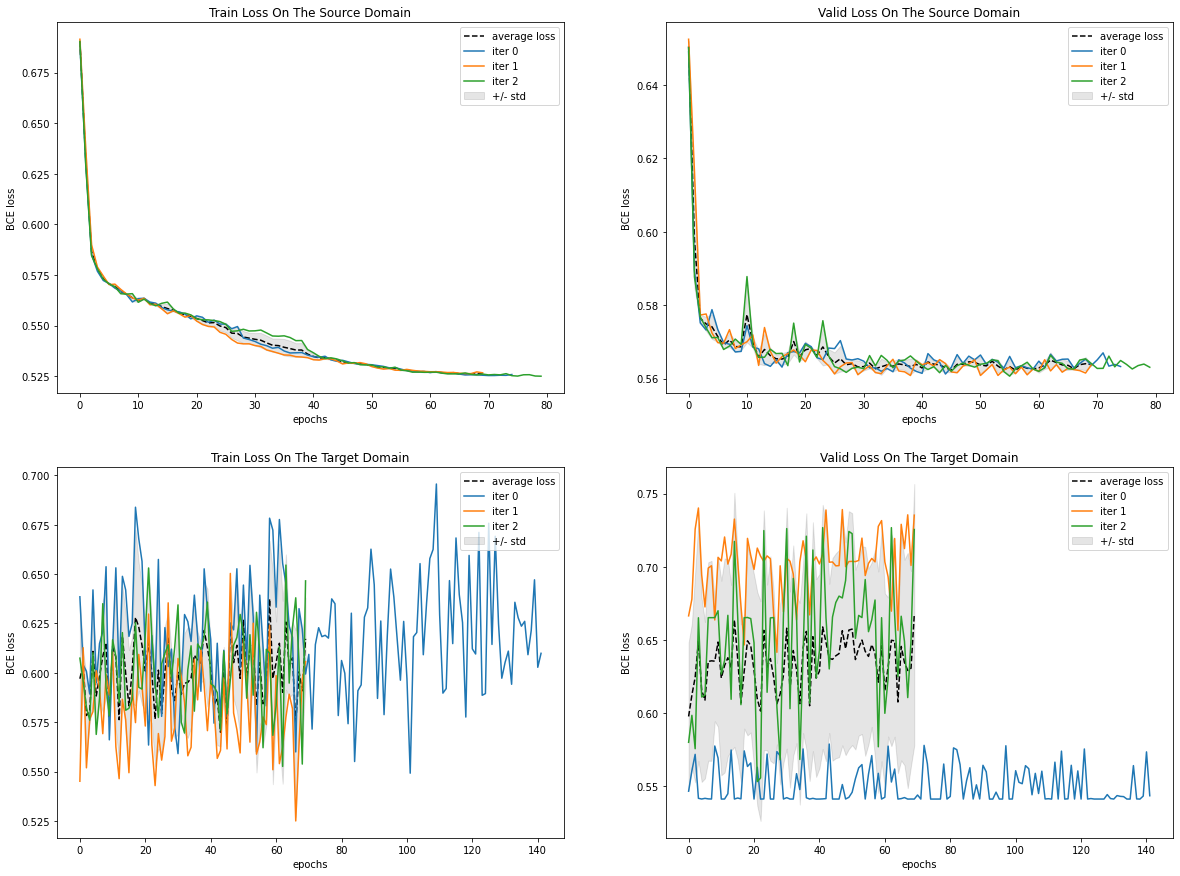

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

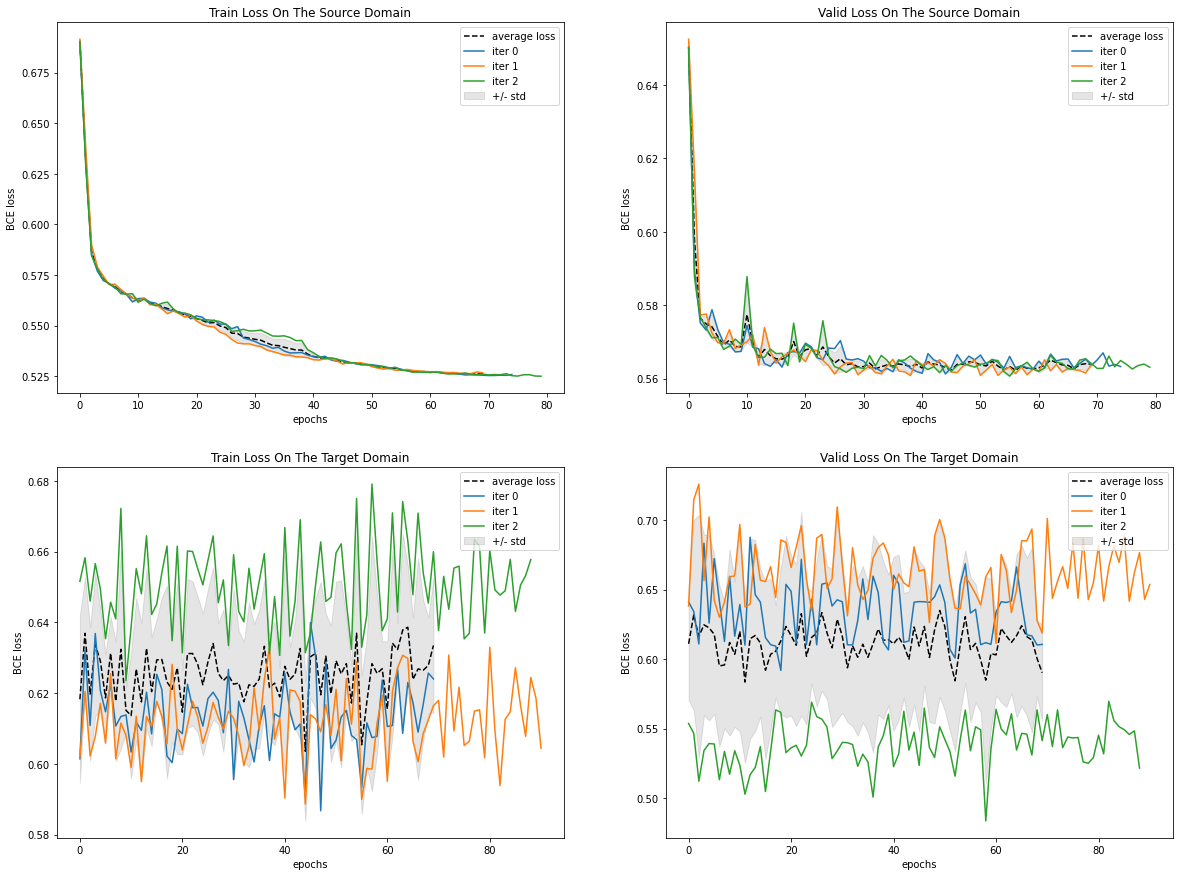

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

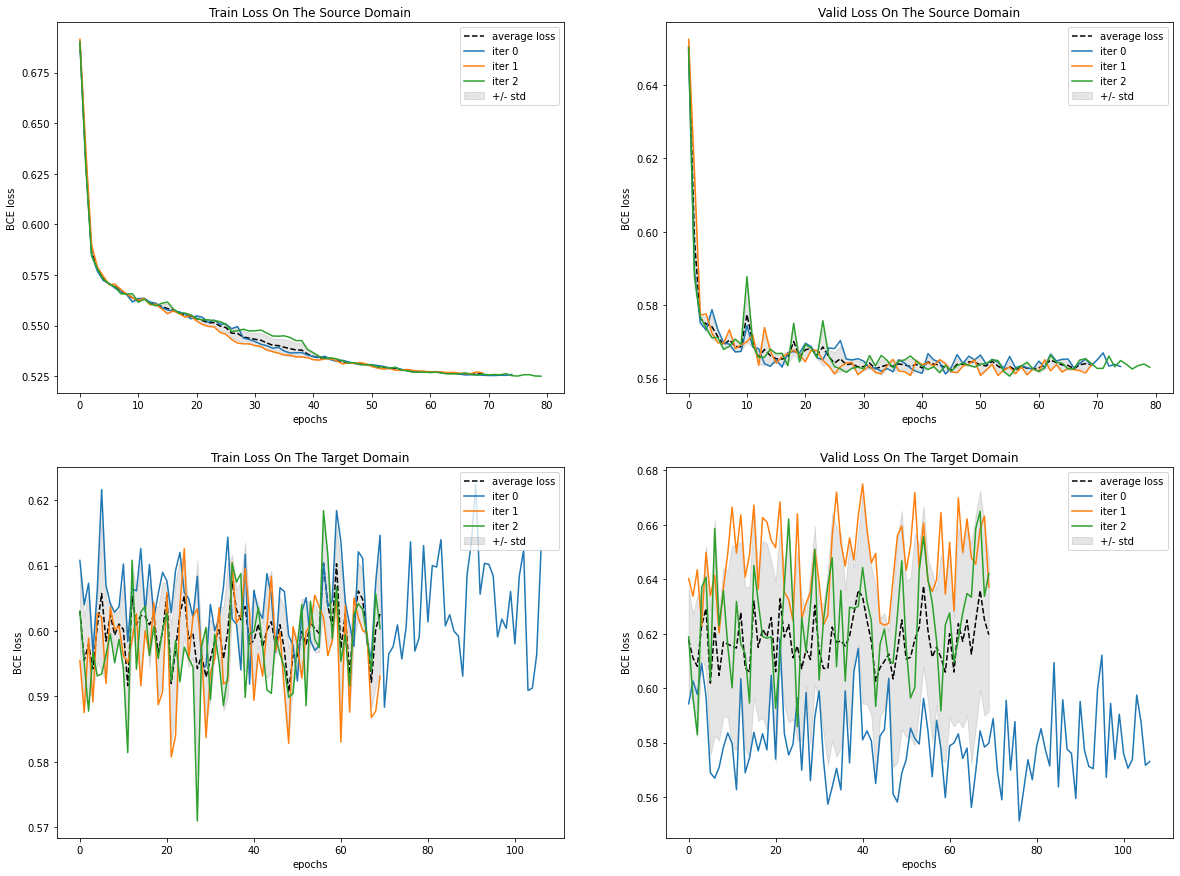

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

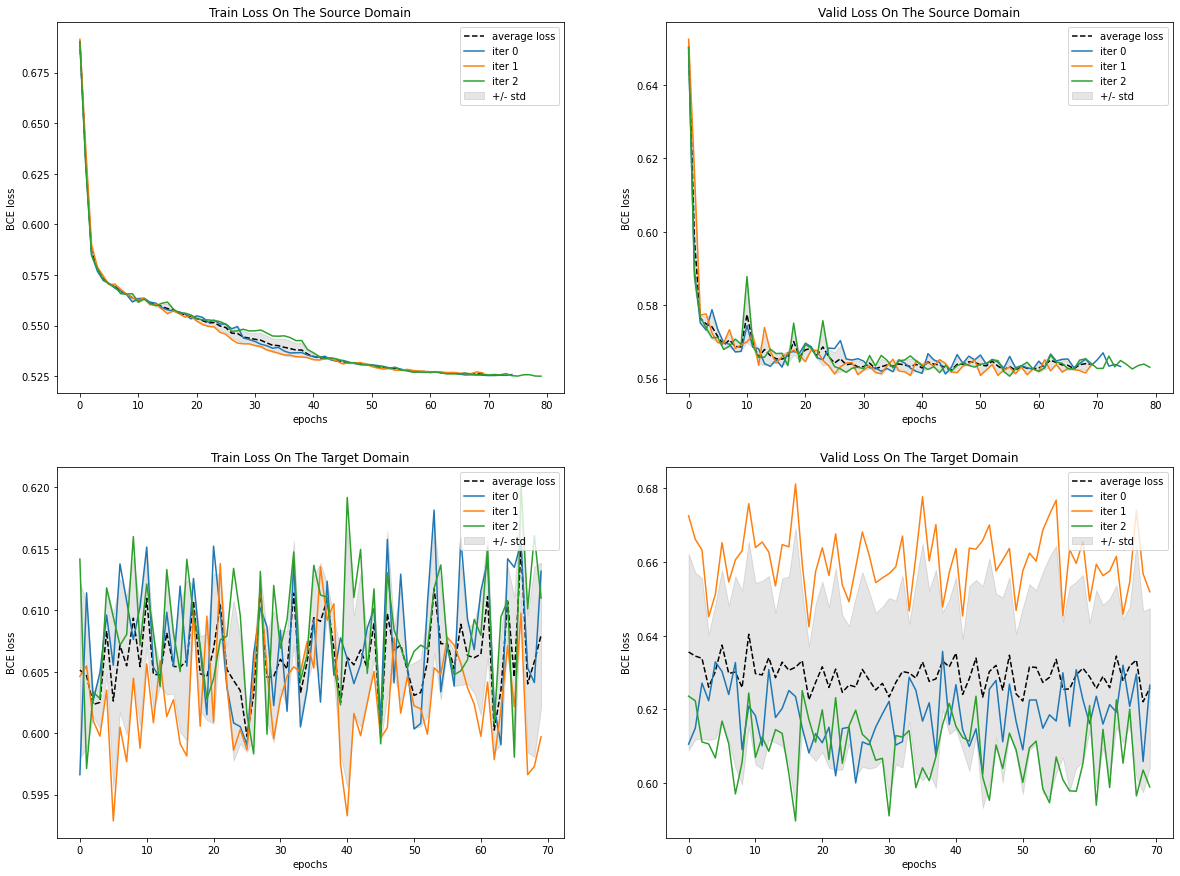

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

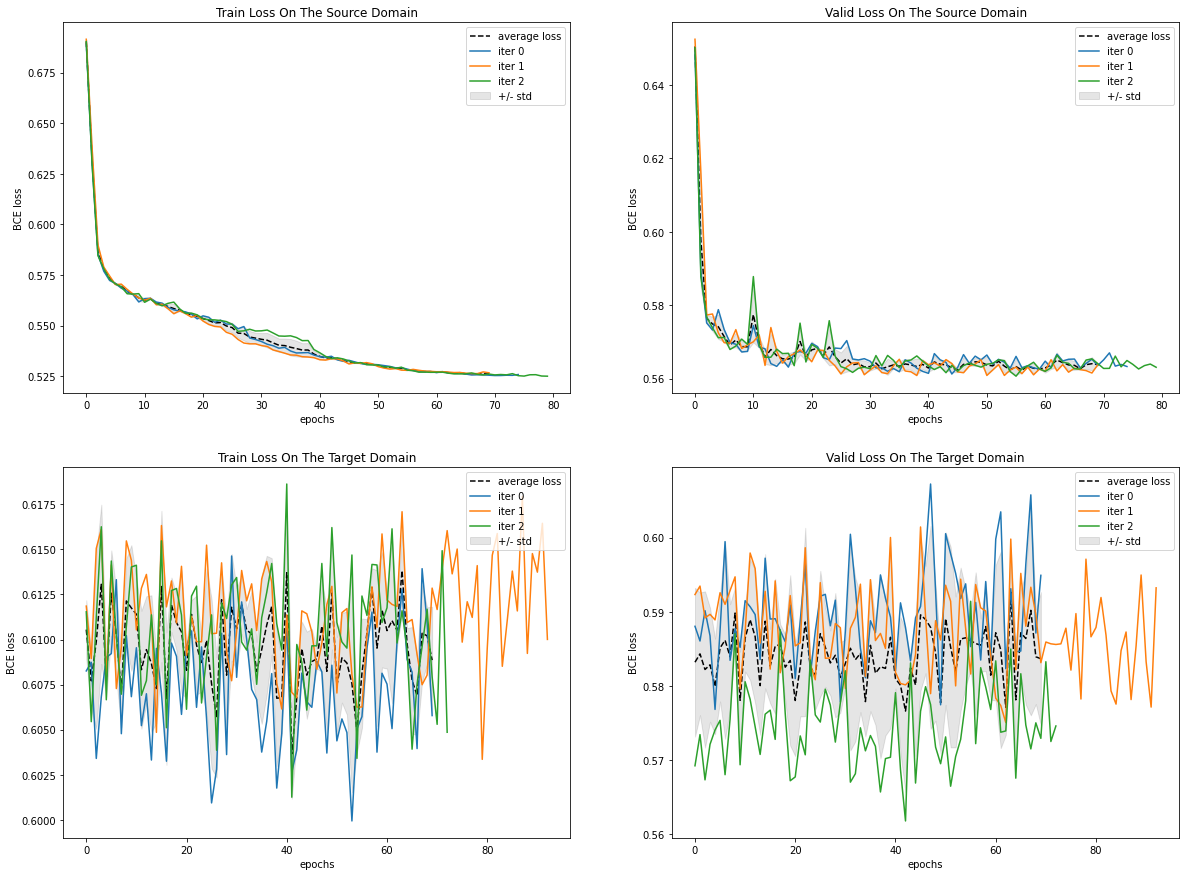

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

# Visualize training and validation accuracies for the two training phases

In [34]:
def plot_accuracies(df, phase='target', n_target_samples=20, acc_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{acc_type}_acc'
    max_len = max([len(ele) for ele in subset_df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in subset_df.loc[:, key].values]
    acc = np.stack(stackable)

    avg_acc = np.mean(acc, axis=0)
    upper_ = avg_acc + np.std(acc, axis=0)
    lower_ = avg_acc - np.std(acc, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_acc, 'k--')
    ax.plot(acc.T)
    ax.legend(['average accuracy', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='lower right')

    ax.set_title(f'{acc_type} Accuracy on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('Accuracy')


## 20 MIMIC samples

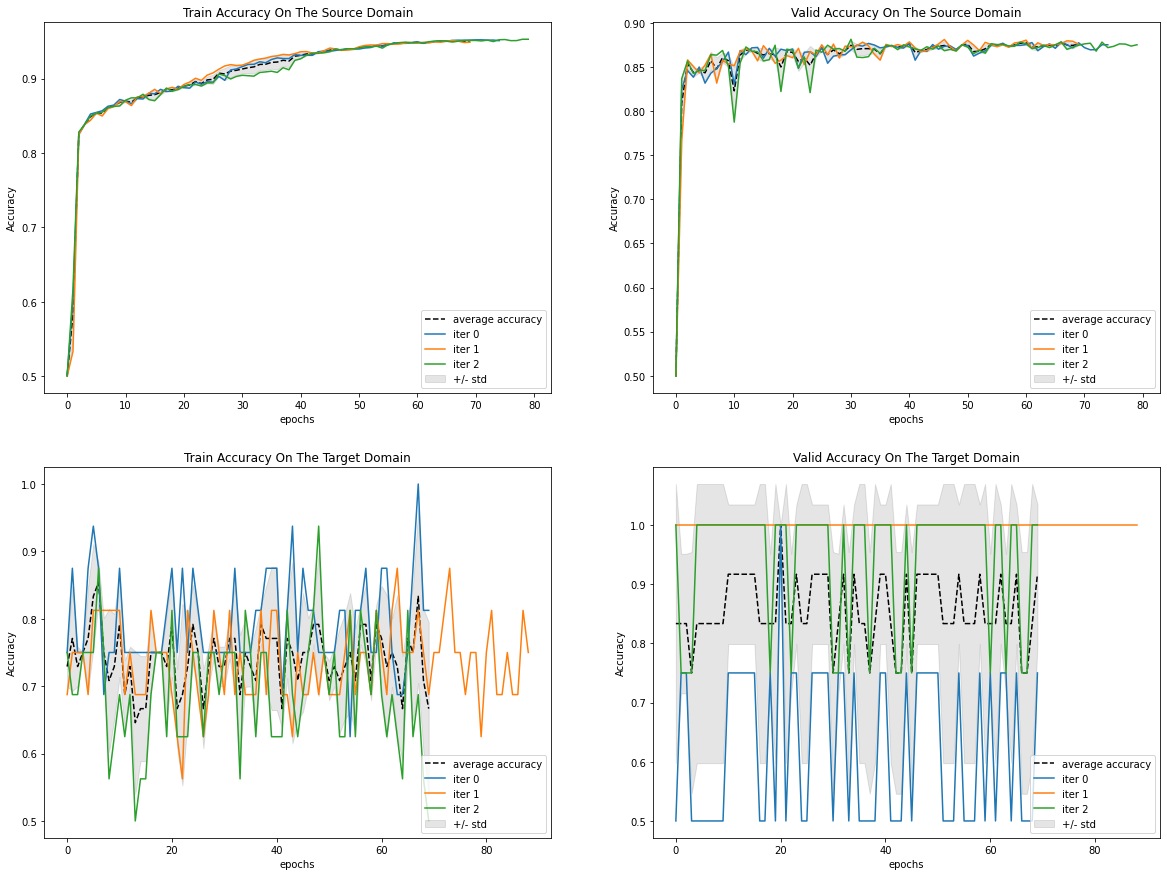

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

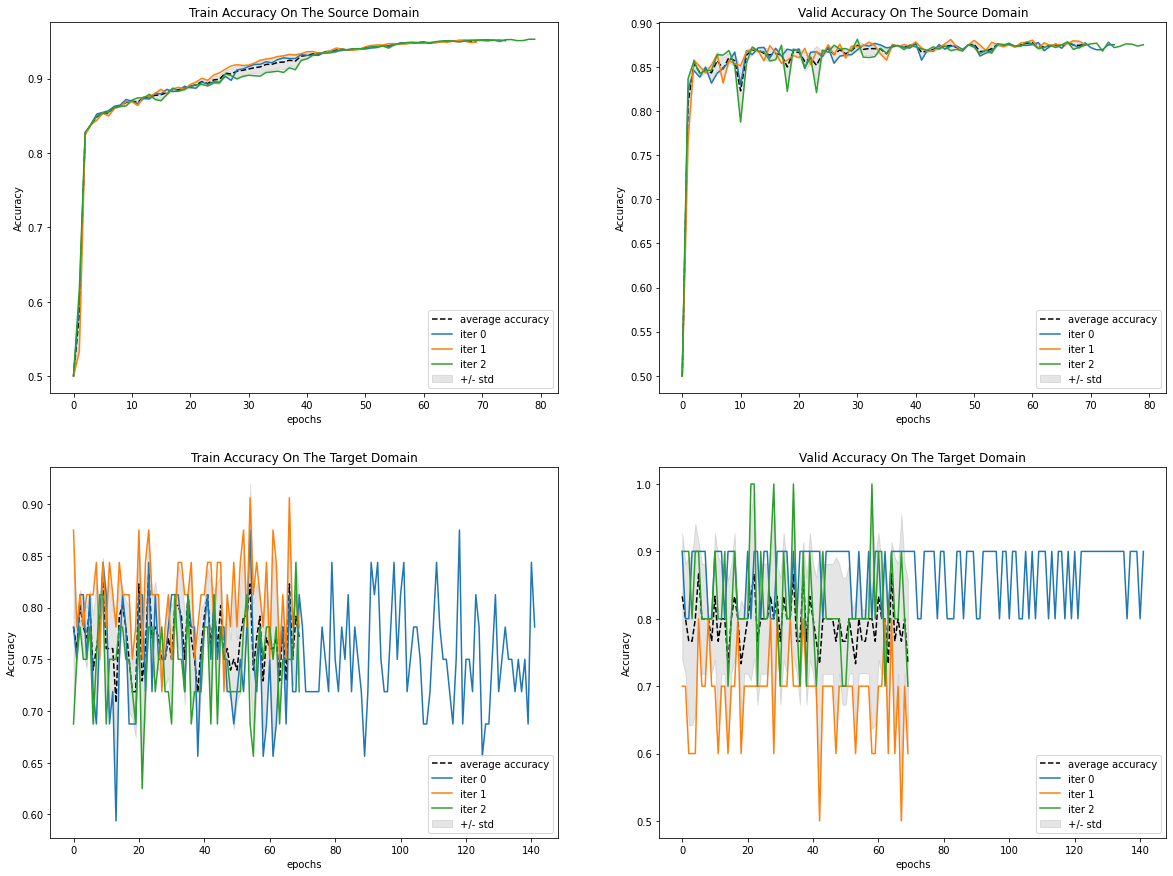

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

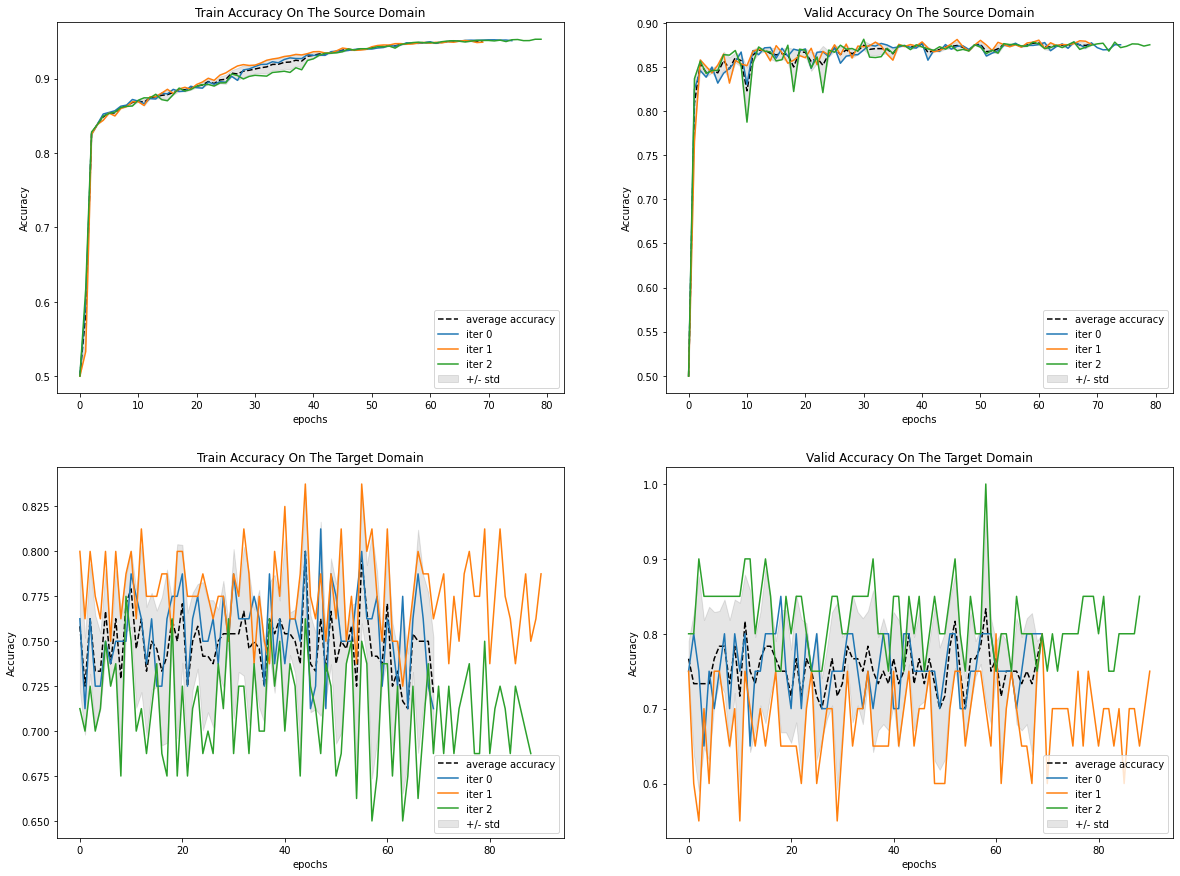

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

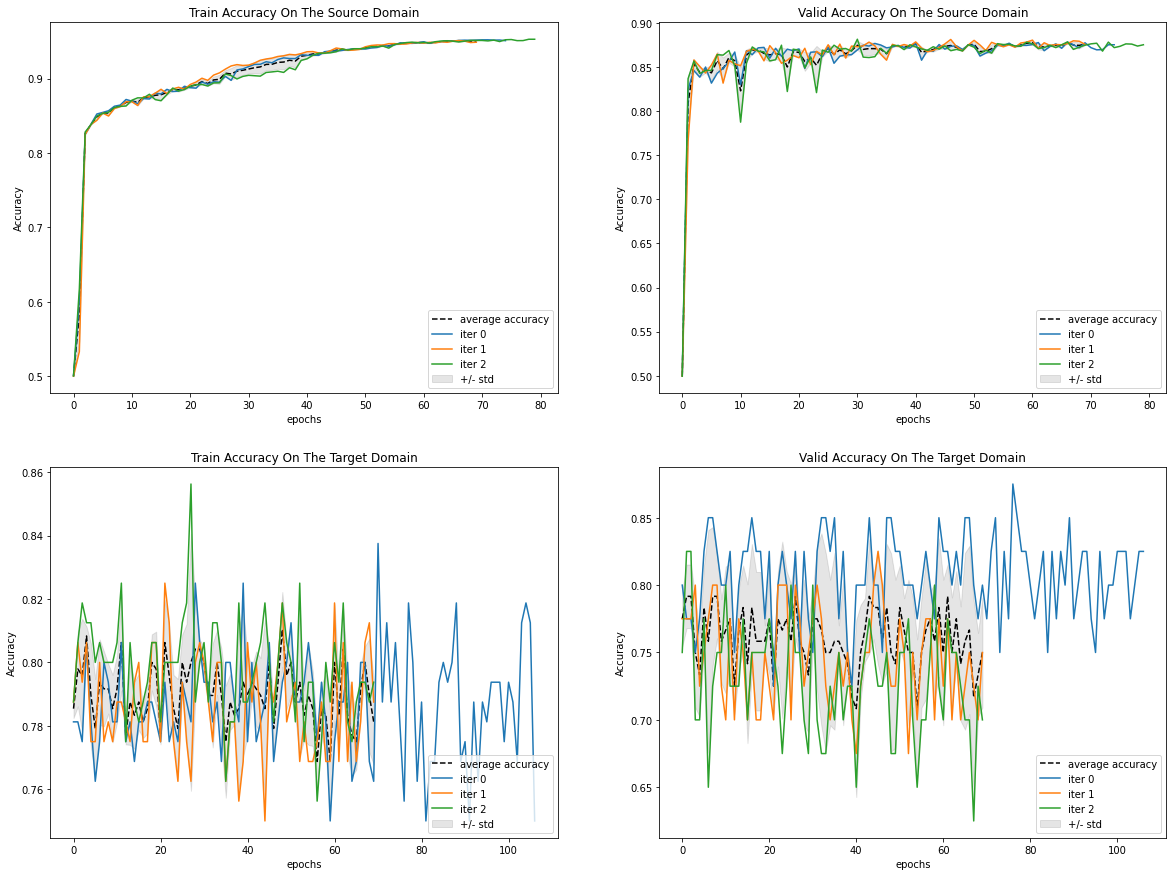

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

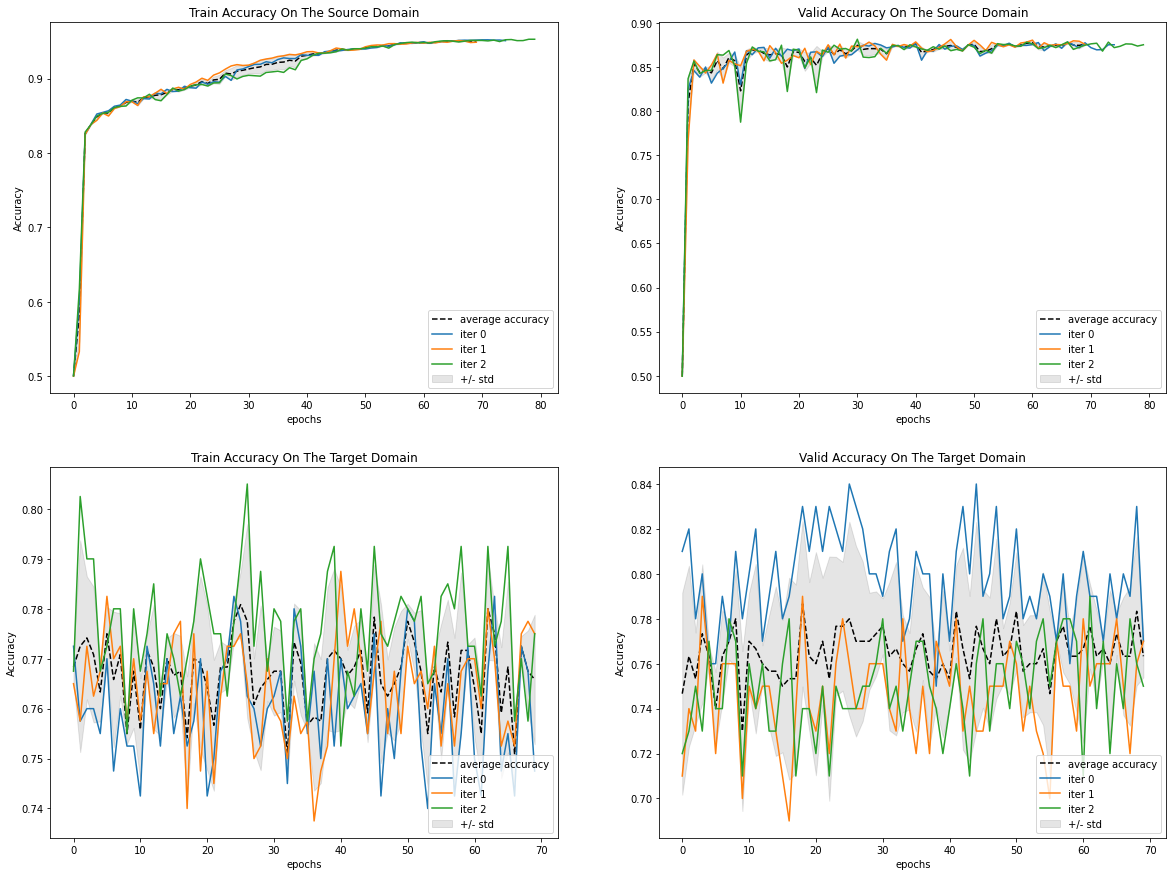

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

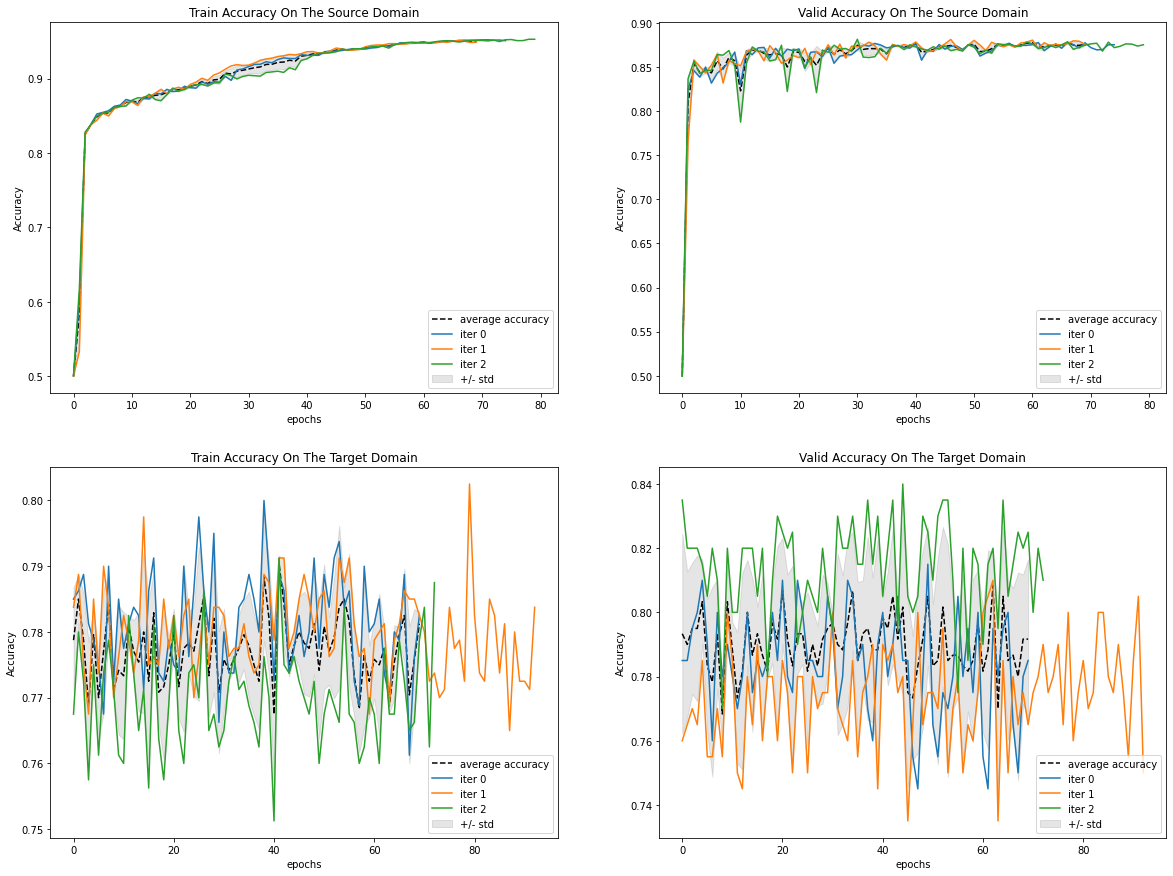

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

# Summarize training metrics for trained models

In [41]:
target_meta = model_meta[model_meta['phase'] == 'target']

training_cols = ['final_train_loss', 'final_valid_loss', 'best_valid_loss', 'final_valid_acc', 'best_valid_acc',
                 'mimic_test_acc', 'chexpert_test_acc']

In [42]:
target_meta.groupby('n_target_samples').mean(numeric_only=True)[training_cols]

,final_train_loss,final_valid_loss,best_valid_loss,final_valid_acc,best_valid_acc,mimic_test_acc,chexpert_test_acc
n_target_samples,,,,,,,
20,0.656303,0.507355,0.472466,0.916667,1.000000,0.769992,0.795917
50,0.620719,0.668091,0.578649,0.733333,0.900000,0.766274,0.781542
100,0.628747,0.595291,0.562293,0.800000,0.883333,0.763349,0.771292
200,0.601981,0.617421,0.584805,0.758333,0.841667,0.765522,0.774208
500,0.607964,0.625823,0.610761,0.763333,0.806667,0.765522,0.770917
1000,0.606882,0.587588,0.571249,0.781667,0.821667,0.765981,0.766792
